In [187]:
import numpy as np
import numpy.random as rand

import torch
import torch.nn as nn

from torch import autograd
from torch.nn import functional as F
from torch import optim

import matplotlib.pyplot as plt

In [188]:
# Converts integers 'x' into bits of length 'k'
def num_to_bin(x, k):
    bin_list = []
    for i in range(k):
        bin_list.append(x%2)
        x = int(x/2)
    return bin_list[::-1]

# Converts bits 'x' into integers
def input_to_number(x):
    m = x.shape[0]
    n = x.shape[1]
    num = torch.empty(m,)
    for i in range(m):
        add = 0
        for j in range(n):
            add = add + x[i,j]*2**(n-1-j)
        num[i] = add
    num = num.long()
    return num

# Adds AWGN Noise
def Channel(x, Noise_var):
    return x + torch.randn(x.shape[1],)*Noise_var

In [189]:
class Net(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # Layers at the transmitter
        self.input      = nn.Linear(in_size, hidden_size)
        self.h1         = nn.Linear(hidden_size, hidden_size)
        self.h2         = nn.Linear(hidden_size, hidden_size)
        self.output     = nn.Linear(hidden_size, out_size)
        
        # Layers at the receiver
        self.rec_input  = nn.Linear(out_size, hidden_size)
        self.rec_h1     = nn.Linear(hidden_size, hidden_size)
        self.rec_h2     = nn.Linear(hidden_size, hidden_size)
        self.rec_output = nn.Linear(hidden_size, 2**in_size)
    
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.output(x)
        x = 2*torch.sigmoid(x) - 1
        y = x
        x = Channel(x,.25)
        z = x
        x = F.relu(self.rec_input(x))
        x = F.relu(self.rec_h1(x))
        x = F.relu(self.rec_h2(x))
        x = F.log_softmax(self.rec_output(x), dim = 1)
        return x,y,z

In [190]:
R = 4
n = 1
k = n*R

num_bits    = k*2**k   # Set the number of bits as constant
batch_size  = 2**k     # Make the batch size constant
num_batch   = int(num_bits/(batch_size*k))

random_data = 0

In [191]:
if random_data == 1:
    data = rand.randint(2, size = (num_bits, ))
else:
    data = []
    for i in range(2**k):
        data.append(num_to_bin(i, k))
    data = np.asarray(data)

In [192]:
input = torch.from_numpy(data)
input = input.view(num_batch, batch_size, k)
input = input.float()
input = autograd.Variable(input)

In [193]:
model     = Net(in_size = k, hidden_size = 32, out_size = 2*n)
optimizer = optim.Adam(model.parameters(), lr = 0.005)
criterion = nn.NLLLoss()

In [194]:
epochs   = 10000
loss_vec = []

# Training
for i in range(epochs):
    for j in range(input.shape[0]):
        nn_in     = input[j]
        optimizer.zero_grad()
        out,x1,x2      = model(nn_in)       
        input_num = input_to_number(nn_in)
        loss      = criterion(out, input_num)     # Output == Input
        loss.backward()
        optimizer.step()
        loss_vec.append(loss.item())

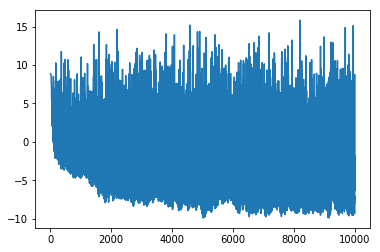

In [195]:
# Testing
test_input = input[0]
out,x1,x2 = model(test_input)
out_ind = torch.argmax(out, dim = 1)
input_num = input_to_number(test_input)
error = (out_ind != input_num)   
plt.plot(20*np.log10(loss_vec))
plt.show()

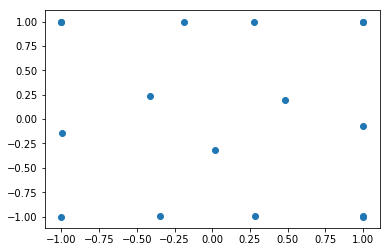

In [196]:
Tx = x1.detach().numpy()
Rx = x2.detach().numpy()

plt.figure();
plt.scatter(Tx[:,0],Tx[:,1])
plt.show()



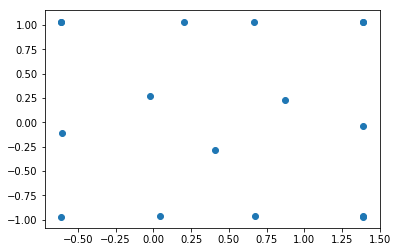

In [197]:
plt.figure();
plt.scatter(Rx[:,0],Rx[:,1])
plt.show()